# sequence prediction sandbox


In [1]:
import torch
from torch import nn

from itertools import product
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import utils as u

In [2]:
# create all possible n-mers for 6 and 8
seqs6 = [''.join(x) for x in product(['A','C','G','T'], repeat=6)]
print('Total 6mers:',len(seqs6))

seqs8 = [''.join(x) for x in product(['A','C','G','T'], repeat=8)]
print('Total 8mers:',len(seqs8))

Total 6mers: 4096
Total 8mers: 65536


In [3]:
# if you want to down select
seqs6_200 = u.downselect_list(seqs6,200)
seqs8_200 = u.downselect_list(seqs8,200)

In [4]:
score_dict = {
    'A':20,
    'C':17,
    'G':14,
    'T':11
}
def score_seqs(seqs):
    data = []
    for seq in seqs:
        score = np.mean([score_dict[base] for base in seq])
        data.append([seq,score])
        
    df = pd.DataFrame(data, columns=['seq','score'])
    return df
                  
def score_seqs_motif(seqs):
    data = []
    for seq in seqs:
        score = np.mean([score_dict[base] for base in seq])
        if 'TAT' in seq:
            score += 10
        if 'GCG' in seq:
            score -= 10
        data.append([seq,score])
        
    df = pd.DataFrame(data, columns=['seq','score'])
    return df
    

In [5]:
mer6 = score_seqs(seqs6)
mer6.head()

,seq,score
0,AAAAAA,20.0
1,AAAAAC,19.5
2,AAAAAG,19.0
3,AAAAAT,18.5
4,AAAACA,19.5


In [6]:
mer8 = score_seqs(seqs8)
mer8.head()

,seq,score
0,AAAAAAAA,20.000
1,AAAAAAAC,19.625
2,AAAAAAAG,19.250
3,AAAAAAAT,18.875
4,AAAAAACA,19.625


In [69]:
mer8_motif[mer8['seq']=='TGCGTTTT']

,seq,score,oh
59135,TGCGTTTT,2.5,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, ..."


In [7]:
mer6_motif = score_seqs_motif(seqs6)
mer8_motif = score_seqs_motif(seqs8)


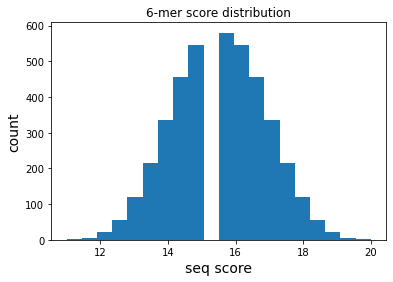

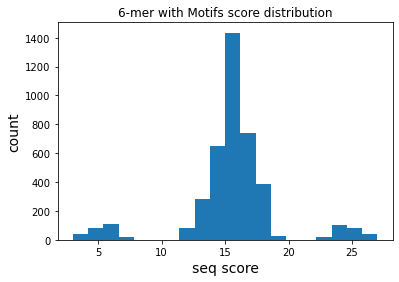

In [8]:
plt.hist(mer6['score'].values,bins=20)
plt.title("6-mer score distribution")
plt.xlabel("seq score",fontsize=14)
plt.ylabel("count",fontsize=14)
plt.show()

plt.hist(mer6_motif['score'].values,bins=20)
plt.title("6-mer with Motifs score distribution")
plt.xlabel("seq score",fontsize=14)
plt.ylabel("count",fontsize=14)
plt.show()

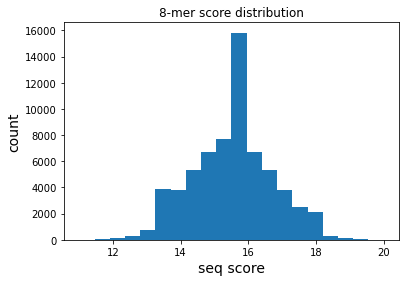

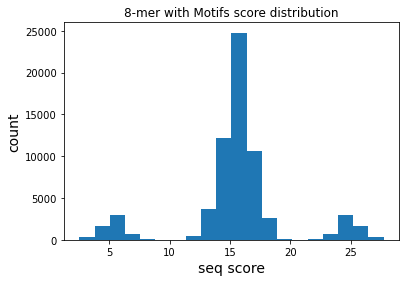

In [9]:
plt.hist(mer8['score'].values,bins=20)
plt.title("8-mer score distribution")
plt.xlabel("seq score",fontsize=14)
plt.ylabel("count",fontsize=14)
plt.show()

plt.hist(mer8_motif['score'].values,bins=20)
plt.title("8-mer with Motifs score distribution")
plt.xlabel("seq score",fontsize=14)
plt.ylabel("count",fontsize=14)
plt.show()

### Define some basic model archs for Linear and CNN

In [10]:
class DNA_Linear_Shallow(nn.Module):
    def __init__(self, seq_len):
        super().__init__()
        self.seq_len = seq_len
        
        self.lin = nn.Linear(4*seq_len, 1)

    def forward(self, xb):
        # Linear wraps up the weights/bias dot product operations
        out = self.lin(xb)
        #print("Lin out shape:", out.shape)
        return out
    
class DNA_Linear_Deep(nn.Module):
    def __init__(self, seq_len,h1_size):
        super().__init__()
        self.seq_len = seq_len
        
        self.lin = nn.Sequential(
            nn.Linear(4*seq_len, h1_size),
            nn.ReLU(inplace=True),
            nn.Linear(h1_size, 1),
            nn.ReLU(inplace=True)
        )

    def forward(self, xb):
        # Linear wraps up the weights/bias dot product operations
        out = self.lin(xb)
        #print("Lin out shape:", out.shape)
        return out
    

    
class DNA_CNN(nn.Module):
    def __init__(self,
                 seq_len,
                 num_filters=32,
                 kernel_size=3):
        super().__init__()
        self.seq_len = seq_len
        
        self.conv_net = nn.Sequential(
            nn.Conv1d(4, num_filters, kernel_size=kernel_size),
            nn.ReLU(inplace=True),
            nn.Flatten(),
            nn.Linear(num_filters*(seq_len-kernel_size+1), 10),
            nn.ReLU(inplace=True),
            nn.Linear(10, 1),
        ) 

    def forward(self, xb):
        # reshape view to batch_ssize x 4channel x seq_len
        # permute to put channel in correct order
        xb = xb.view(-1,self.seq_len,4).permute(0,2,1) 
        #print(xb.shape)
        out = self.conv_net(xb)
        #print("CNN out shape:",out.shape)
        return out

# Single Task, Simple Sequence Regression
#### Linear Regression

In [11]:
mer6_train_dl, mer6_test_dl, mer6_train_df, mer6_test_df = u.build_dataloaders_single(mer6,batch_size=11)

In [12]:
def plot_train_test_hist(train_df, test_df,bins=10):
    ''' Check distribution of train/test scores, sanity check that its not skewed'''
    plt.hist(train_df['score'].values,bins=bins,label="train")
    plt.hist(test_df['score'].values,bins=bins,label='test')
    plt.legend()
    plt.xlabel("seq score",fontsize=14)
    plt.ylabel("count",fontsize=14)
    plt.show()

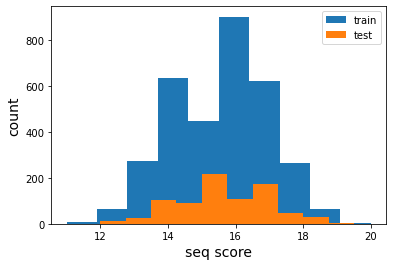

In [13]:
plot_train_test_hist(mer6_train_df, mer6_test_df)

#### Run linear model

/home/ewilson6/anaconda3/envs/torch/lib/python3.8/site-packages/torch/autograd/__init__.py:130: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 9000). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  /opt/conda/conda-bld/pytorch_1607369981906/work/c10/cuda/CUDAFunctions.cpp:100.)
  Variable._execution_engine.run_backward(


0 0.0983895373780553
1 0.004945033160038292
2 0.0002495199876337698
3 1.2764917396896458e-05
4 6.609105070180437e-07
5 3.4514413503910366e-08
6 1.871846569480002e-09
7 1.5930797943522953e-10
8 6.092061701392187e-11
9 4.90639118510157e-11
10 4.707855151832612e-11
11 4.141306469076592e-11
12 4.0781964172969e-11
13 3.971497181552674e-11
14 3.7134003204269146e-11
15 3.60603555675182e-11
16 3.5166389234478416e-11
17 3.5278412136019455e-11
18 3.4027302395567415e-11
19 3.2973619490327424e-11


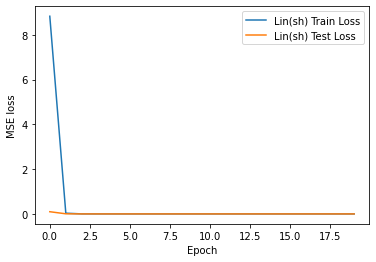

In [14]:
seq_len = len(mer6_train_df['seq'].values[0])
#hidden_layer_size = 24

mer6_model_lin_s = DNA_Linear_Shallow(seq_len)

mer6_train_losses, mer6_test_losses = u.run_model(mer6_train_dl, mer6_test_dl, mer6_model_lin_s)

# to plot loss
mer6_lin_s_data_label = list(zip([mer6_train_losses,mer6_test_losses], ['Lin(sh) Train Loss','Lin(sh) Test Loss']))
u.quick_loss_plot(mer6_lin_s_data_label)

In [15]:
def quick_test(model,oracle):
    '''Spot check predictions for a few sequences '''
    seqs1 = ['AAAAAA', 'CCCCCC','GGGGGG','TTTTTT']
    seqs2 = ['AACCAA','CCGGGG','GGGTAA', 'TTTCGT','TGTAAT']
    seqsTAT = ['TATAAA','CCTATC','GTATGG','TTTATT']
    seqsGCG = ['AAGCGA','CGCGCC','GGGCGG','TTGCGT']
    TATGCG =  ['TATGCG','GCGTAT']

    for seqs in [seqs1, seqs2, seqsTAT, seqsGCG, TATGCG]:
        u.quick_seq_pred(model, seqs, oracle)
        print()

In [16]:
oracle_6mer = scoring = dict(mer6[['seq','score']].values)
quick_test(mer6_model_lin_s, oracle_6mer)

AAAAAA: pred:20.000 actual:20.000 (0.000)
CCCCCC: pred:17.000 actual:17.000 (-0.000)
GGGGGG: pred:14.000 actual:14.000 (-0.000)
TTTTTT: pred:11.000 actual:11.000 (-0.000)

AACCAA: pred:19.000 actual:19.000 (0.000)
CCGGGG: pred:15.000 actual:15.000 (-0.000)
GGGTAA: pred:15.500 actual:15.500 (0.000)
TTTCGT: pred:12.500 actual:12.500 (-0.000)
TGTAAT: pred:14.500 actual:14.500 (0.000)

TATAAA: pred:17.000 actual:17.000 (0.000)
CCTATC: pred:15.500 actual:15.500 (-0.000)
GTATGG: pred:14.000 actual:14.000 (-0.000)
TTTATT: pred:12.500 actual:12.500 (-0.000)

AAGCGA: pred:17.500 actual:17.500 (0.000)
CGCGCC: pred:16.000 actual:16.000 (-0.000)
GGGCGG: pred:14.500 actual:14.500 (-0.000)
TTGCGT: pred:13.000 actual:13.000 (-0.000)

TATGCG: pred:14.500 actual:14.500 (-0.000)
GCGTAT: pred:14.500 actual:14.500 (-0.000)



# Single task Regression with Motifs
### Linear Model

In [17]:
mer6motif_train_dl, mer6motif_test_dl, mer6motif_train_df, mer6motif_test_df = u.build_dataloaders_single(mer6_motif,batch_size=13)

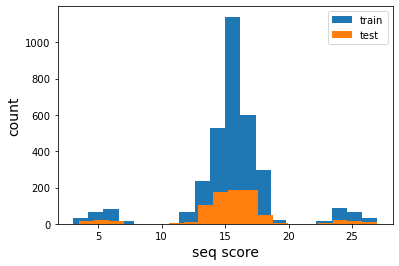

In [18]:
plot_train_test_hist(mer6motif_train_df, mer6motif_test_df,bins=20)

0 9.91281695772962
1 9.491920773866699
2 9.416969939557518
3 9.433645914531336
4 9.440130264293856
5 9.435893107914342
6 9.423693616797284
7 9.419551500750751
8 9.450955342374197
9 9.43783170013893
10 9.440222180180433
11 9.48128918176744
12 9.4587357445461
13 9.417826388521892
14 9.44898994259718
15 9.437635686630156
16 9.487153936595451
17 9.503956018424615
18 9.469618663555238
19 9.466615892619622


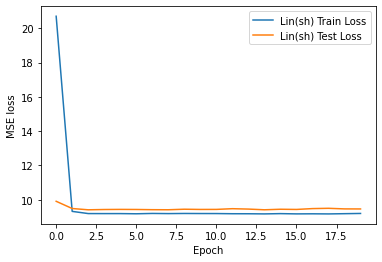

In [19]:
seq_len = len(mer6motif_train_df['seq'].values[0])
hidden_layer_size = 24

mer6motif_model_lin_s = DNA_Linear_Shallow(seq_len)

mer6motif_train_losses_lin_s, mer6motif_test_losses_lin_s = u.run_model(mer6motif_train_dl, mer6motif_test_dl, mer6motif_model_lin_s)

# to plot loss
mer6motif_lin_s_data_label = list(zip([mer6motif_train_losses_lin_s,mer6motif_test_losses_lin_s], ['Lin(sh) Train Loss','Lin(sh) Test Loss']))
u.quick_loss_plot(mer6motif_lin_s_data_label)

In [20]:
oracle_6mer_motif = scoring = dict(mer6_motif[['seq','score']].values)
quick_test(mer6motif_model_lin_s,oracle_6mer_motif)

AAAAAA: pred:22.320 actual:20.000 (-2.320)
CCCCCC: pred:14.864 actual:17.000 (2.136)
GGGGGG: pred:9.533 actual:14.000 (4.467)
TTTTTT: pred:15.889 actual:11.000 (-4.889)

AACCAA: pred:18.956 actual:19.000 (0.044)
CCGGGG: pred:10.999 actual:15.000 (4.001)
GGGTAA: pred:14.950 actual:15.500 (0.550)
TTTCGT: pred:14.517 actual:12.500 (-2.017)
TGTAAT: pred:17.616 actual:14.500 (-3.116)

TATAAA: pred:20.757 actual:27.000 (6.243)
CCTATC: pred:17.503 actual:25.500 (7.997)
GTATGG: pred:14.952 actual:24.000 (9.048)
TTTATT: pred:16.861 actual:22.500 (5.639)

AAGCGA: pred:15.733 actual:7.500 (-8.233)
CGCGCC: pred:13.187 actual:6.000 (-7.187)
GGGCGG: pred:10.727 actual:4.500 (-6.227)
TTGCGT: pred:12.554 actual:3.000 (-9.554)

TATGCG: pred:14.917 actual:14.500 (-0.417)
GCGTAT: pred:14.496 actual:14.500 (0.004)



### Deeper layered linear

0 10.223019456572649
1 9.200387356484809
2 8.867248381637946
3 8.307315236911542
4 7.742069478732784
5 7.434815312594902
6 6.995687153862744
7 6.815583767542025
8 6.272779217289715
9 6.672840537675997
10 5.685780715942383
11 5.440889409693276
12 5.220378561717708
13 5.256897386399711
14 5.091027357520127
15 5.295080611763931
16 5.037257059899772
17 4.958375017526673
18 4.840794553989317
19 4.662570577132993


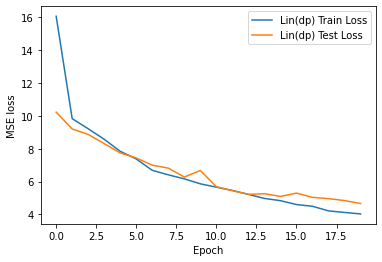

In [21]:
seq_len = len(mer6motif_train_df['seq'].values[0])
hidden_layer_size = 24

mer6motif_model_lin_d = DNA_Linear_Deep(seq_len,hidden_layer_size)

mer6motif_train_losses_lin_d, mer6motif_test_losses_lin_d = u.run_model(
    mer6motif_train_dl, 
    mer6motif_test_dl, 
    mer6motif_model_lin_d)

# to plot loss
mer6motif_lin_d_data_label = list(zip([mer6motif_train_losses_lin_d,
                                       mer6motif_test_losses_lin_d], 
                                      ['Lin(dp) Train Loss',
                                       'Lin(dp) Test Loss']))
u.quick_loss_plot(mer6motif_lin_d_data_label)

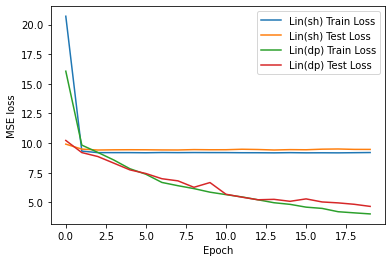

In [22]:
u.quick_loss_plot(
    mer6motif_lin_s_data_label + \
    mer6motif_lin_d_data_label
)

Running LinearShallow_6mer


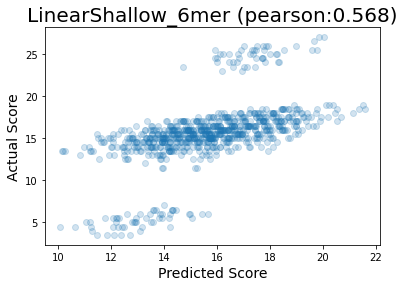

Running LinearDeep_6mer


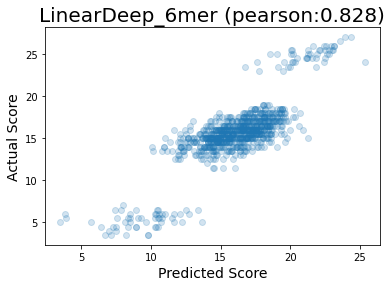

In [23]:
models = [
    ("LinearShallow_6mer",mer6motif_model_lin_s),
    ("LinearDeep_6mer",mer6motif_model_lin_d),
]

seqs = mer6motif_test_df['seq'].values
task = "6mer_TATGCGmotif"

dfs = u.parity_pred(models, seqs, oracle_6mer_motif,task,alt=True)

### CNN Model

0 6.505266453870913
1 2.7018195636388733
2 0.6728990431965851
3 0.3003732568061933
4 0.1807675100635828
5 0.1795115140562014
6 0.3298908668411214
7 0.3358770614262761
8 0.1498589128460281
9 0.2366242687785771
10 0.18408274099049043
11 0.19881071876734496
12 0.5098746552336507
13 0.13888553124057448
14 0.1412601332202917
15 0.15863854683163325
16 0.1796550039338266
17 0.3953363073490015
18 0.2375718220909376
19 0.13510965925709503


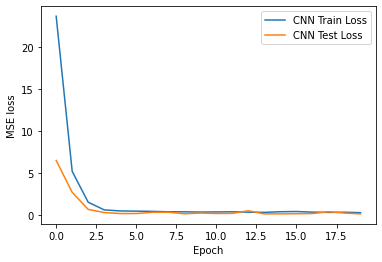

In [24]:
seq_len = len(mer6motif_train_df['seq'].values[0])

mer6motif_model_cnn = DNA_CNN(seq_len, num_filters=31,kernel_size=3)

mer6motif_train_losses_cnn, mer6motif_test_losses_cnn = u.run_model(mer6motif_train_dl, mer6motif_test_dl, mer6motif_model_cnn, lr=0.01)

# to plot loss
mer6motif_cnn_data_label = list(zip([mer6motif_train_losses_cnn,mer6motif_test_losses_cnn], ['CNN Train Loss','CNN Test Loss']))
u.quick_loss_plot(mer6motif_cnn_data_label)

In [25]:
quick_test(mer6motif_model_cnn, oracle_6mer_motif)

AAAAAA: pred:20.129 actual:20.000 (-0.129)
CCCCCC: pred:16.888 actual:17.000 (0.112)
GGGGGG: pred:13.842 actual:14.000 (0.158)
TTTTTT: pred:11.425 actual:11.000 (-0.425)

AACCAA: pred:18.951 actual:19.000 (0.049)
CCGGGG: pred:15.007 actual:15.000 (-0.007)
GGGTAA: pred:15.796 actual:15.500 (-0.296)
TTTCGT: pred:12.599 actual:12.500 (-0.099)
TGTAAT: pred:14.884 actual:14.500 (-0.384)

TATAAA: pred:26.627 actual:27.000 (0.373)
CCTATC: pred:25.544 actual:25.500 (-0.044)
GTATGG: pred:24.224 actual:24.000 (-0.224)
TTTATT: pred:22.771 actual:22.500 (-0.271)

AAGCGA: pred:7.316 actual:7.500 (0.184)
CGCGCC: pred:5.731 actual:6.000 (0.269)
GGGCGG: pred:4.480 actual:4.500 (0.020)
TTGCGT: pred:3.863 actual:3.000 (-0.863)

TATGCG: pred:14.235 actual:14.500 (0.265)
GCGTAT: pred:14.453 actual:14.500 (0.047)



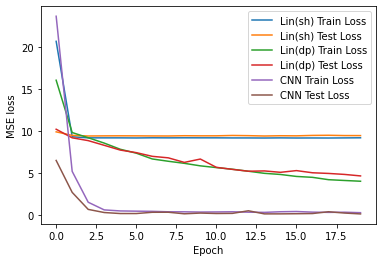

In [26]:
u.quick_loss_plot(
    mer6motif_lin_s_data_label + \
    mer6motif_lin_d_data_label + \
    mer6motif_cnn_data_label
)

# Try with 8 mers

### Single Task Regression


In [27]:
mer8_train_dl, mer8_test_dl, mer8_train_df, mer8_test_df = u.build_dataloaders_single(mer8)

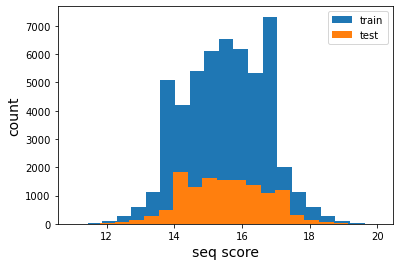

In [28]:
plot_train_test_hist(mer8_train_df, mer8_test_df,bins=20)

0 1.0483177342673383e-07
1 5.117545175643274e-11
2 4.1887129575696394e-11
3 3.9088705691787916e-11
4 3.6482338658331794e-11
5 3.5674839476398375e-11
6 3.481890976621598e-11
7 3.436666026361957e-11
8 3.388998734940332e-11
9 3.3335117868335747e-11
10 3.220650626879394e-11
11 3.170194070404566e-11
12 3.17618890841815e-11
13 3.159037010032946e-11
14 3.1110644254367086e-11
15 3.0765524734422384e-11
16 3.0391541182322694e-11
17 3.047154174671719e-11
18 3.039841026485566e-11
19 3.0101860043097557e-11


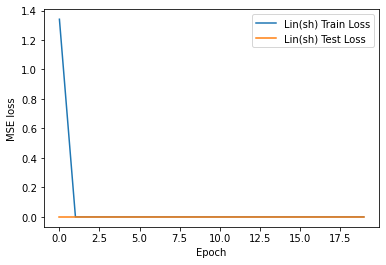

In [30]:
seq_len = len(mer8_train_df['seq'].values[0])
hidden_layer_size = 24

mer8_model_lin_s = DNA_Linear_Shallow(seq_len)

mer8_train_losses_s, mer8_test_losses_s = u.run_model(
    mer8_train_dl, 
    mer8_test_dl, 
    mer8_model_lin_s)

# to plot loss
mer8_lin_s_data_label = list(zip([mer8_train_losses_s,mer8_test_losses_s], ['Lin(sh) Train Loss','Lin(sh) Test Loss']))
u.quick_loss_plot(mer8_lin_s_data_label)

In [31]:
def quick_test8(model, oracle):
    seqs1 = ['AAAAAAAA', 'CCCCCCCC','GGGGGGGG','TTTTTTTT']
    seqs2 = ['AACCAACA','CCGGCGCG','GGGTAAGG', 'TTTCGTTT','TGTAATAC']
    seqsTAT = ['TATAAAAA','CCTATCCC','GTATGGGG','TTTATTTT']
    seqsGCG = ['AAGCGAAA','CGCGCCCC','GGGCGGGG','TTGCGTTT']
    TATGCG =  ['ATATGCGA','TGCGTATT']

    for seqs in [seqs1, seqs2, seqsTAT, seqsGCG, TATGCG]:
        u.quick_seq_pred(model, seqs, oracle)
        print()

In [32]:
oracle_8mer = scoring = dict(mer8[['seq','score']].values)
quick_test8(mer8_model_lin_s, oracle_8mer)

AAAAAAAA: pred:20.000 actual:20.000 (0.000)
CCCCCCCC: pred:17.000 actual:17.000 (0.000)
GGGGGGGG: pred:14.000 actual:14.000 (-0.000)
TTTTTTTT: pred:11.000 actual:11.000 (-0.000)

AACCAACA: pred:18.875 actual:18.875 (0.000)
CCGGCGCG: pred:15.500 actual:15.500 (-0.000)
GGGTAAGG: pred:15.125 actual:15.125 (-0.000)
TTTCGTTT: pred:12.125 actual:12.125 (-0.000)
TGTAATAC: pred:15.500 actual:15.500 (0.000)

TATAAAAA: pred:17.750 actual:17.750 (0.000)
CCTATCCC: pred:15.875 actual:15.875 (0.000)
GTATGGGG: pred:14.000 actual:14.000 (-0.000)
TTTATTTT: pred:12.125 actual:12.125 (-0.000)

AAGCGAAA: pred:18.125 actual:18.125 (0.000)
CGCGCCCC: pred:16.250 actual:16.250 (0.000)
GGGCGGGG: pred:14.375 actual:14.375 (-0.000)
TTGCGTTT: pred:12.500 actual:12.500 (-0.000)

ATATGCGA: pred:15.875 actual:15.875 (0.000)
TGCGTATT: pred:13.625 actual:13.625 (-0.000)



# Single task Regression with Motifs
### Linear Model

In [34]:
mer8motif_train_dl, \
mer8motif_test_dl, \
mer8motif_train_df, \
mer8motif_test_df = u.build_dataloaders_single(mer8_motif, batch_size=13)

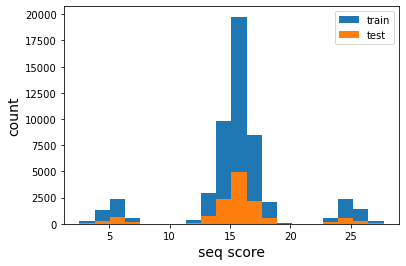

In [35]:
plot_train_test_hist(mer8motif_train_df, mer8motif_test_df,bins=20)

0 12.82830584542141
1 12.769197797044079
2 12.78448287108194
3 12.793392784136405
4 12.87207994844479
5 12.817638236227872
6 12.809667538661655
7 12.829676736263302
8 12.805807999086555
9 12.873453069122455
10 12.80212966694423
11 12.836724030023891
12 12.802128228311464
13 12.81109882254116
14 12.826028993753969
15 12.792945093613119
16 12.788362361033734
17 12.763838345916453
18 12.787020684725489
19 12.839489021805463


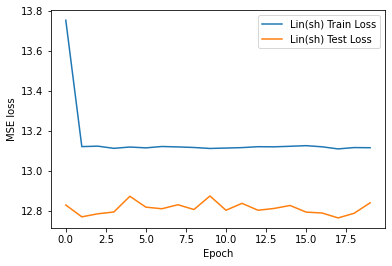

In [36]:
seq_len = len(mer8motif_train_df['seq'].values[0])
hidden_layer_size = 24

mer8motif_model_lin_s = DNA_Linear_Shallow(seq_len)

mer8motif_train_losses_lin_s, mer8motif_test_losses_lin_s = u.run_model(
    mer8motif_train_dl, 
    mer8motif_test_dl, 
    mer8motif_model_lin_s
)

# to plot loss
mer8motif_lin_s_data_label = list(zip([mer8motif_train_losses_lin_s,
                                       mer8motif_test_losses_lin_s], 
                                      ['Lin(sh) Train Loss',
                                       'Lin(sh) Test Loss']))
u.quick_loss_plot(mer8motif_lin_s_data_label)

In [37]:
oracle_8mer_motif = dict(mer8_motif[['seq','score']].values)
quick_test8(mer8motif_model_lin_s,oracle_8mer_motif)

AAAAAAAA: pred:23.532 actual:20.000 (-3.532)
CCCCCCCC: pred:13.733 actual:17.000 (3.267)
GGGGGGGG: pred:7.653 actual:14.000 (6.347)
TTTTTTTT: pred:17.654 actual:11.000 (-6.654)

AACCAACA: pred:19.026 actual:18.875 (-0.151)
CCGGCGCG: pred:10.240 actual:5.500 (-4.740)
GGGTAAGG: pred:14.420 actual:15.125 (0.705)
TTTCGTTT: pred:14.798 actual:12.125 (-2.673)
TGTAATAC: pred:19.647 actual:15.500 (-4.147)

TATAAAAA: pred:22.630 actual:27.750 (5.120)
CCTATCCC: pred:16.962 actual:25.875 (8.913)
GTATGGGG: pred:12.368 actual:24.000 (11.632)
TTTATTTT: pred:18.114 actual:22.125 (4.011)

AAGCGAAA: pred:17.054 actual:8.125 (-8.929)
CGCGCCCC: pred:12.663 actual:6.250 (-6.413)
GGGCGGGG: pred:8.420 actual:4.375 (-4.045)
TTGCGTTT: pred:12.682 actual:2.500 (-10.182)

ATATGCGA: pred:15.813 actual:15.875 (0.062)
TGCGTATT: pred:14.809 actual:13.625 (-1.184)



0 7.1727392202039155
1 3.9965525085074094
2 2.5064366621044596
3 1.4961415208173592
4 1.1142211899713823
5 1.1486783481510239
6 0.9354623772404568
7 0.7371995938452445
8 0.6731086492734266
9 0.6689379506326386
10 0.5658763321468975
11 0.5775774944969246
12 0.5568846759829996
13 0.6363254892629869
14 0.5928491022419906
15 0.5260310936540133
16 0.5297314090458725
17 0.602197859207777
18 0.5296473818646984
19 0.5034844467634103


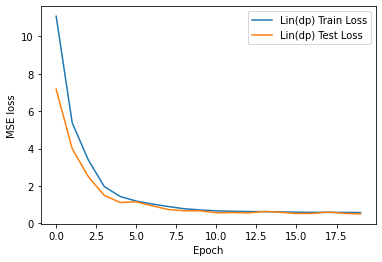

In [38]:
seq_len = len(mer8motif_train_df['seq'].values[0])
hidden_layer_size = 24

mer8motif_model_lin_d = DNA_Linear_Deep(seq_len,hidden_layer_size)

mer8motif_train_losses_lin_d, mer8motif_test_losses_lin_d = u.run_model(
    mer8motif_train_dl, 
    mer8motif_test_dl, 
    mer8motif_model_lin_d
)

# to plot loss
mer8motif_lin_d_data_label = list(zip([mer8motif_train_losses_lin_d,
                                       mer8motif_test_losses_lin_d], 
                                      ['Lin(dp) Train Loss',
                                       'Lin(dp) Test Loss']))
u.quick_loss_plot(mer8motif_lin_d_data_label)

In [39]:
oracle_8mer_motif = dict(mer8_motif[['seq','score']].values)
quick_test8(mer8motif_model_lin_d,oracle_8mer_motif)

AAAAAAAA: pred:20.241 actual:20.000 (-0.241)
CCCCCCCC: pred:17.041 actual:17.000 (-0.041)
GGGGGGGG: pred:14.060 actual:14.000 (-0.060)
TTTTTTTT: pred:13.004 actual:11.000 (-2.004)

AACCAACA: pred:19.038 actual:18.875 (-0.163)
CCGGCGCG: pred:0.000 actual:5.500 (5.500)
GGGTAAGG: pred:15.159 actual:15.125 (-0.034)
TTTCGTTT: pred:13.146 actual:12.125 (-1.021)
TGTAATAC: pred:15.447 actual:15.500 (0.053)

TATAAAAA: pred:26.563 actual:27.750 (1.187)
CCTATCCC: pred:25.483 actual:25.875 (0.392)
GTATGGGG: pred:23.388 actual:24.000 (0.612)
TTTATTTT: pred:22.866 actual:22.125 (-0.741)

AAGCGAAA: pred:8.294 actual:8.125 (-0.169)
CGCGCCCC: pred:6.293 actual:6.250 (-0.043)
GGGCGGGG: pred:4.215 actual:4.375 (0.160)
TTGCGTTT: pred:2.266 actual:2.500 (0.234)

ATATGCGA: pred:15.367 actual:15.875 (0.508)
TGCGTATT: pred:14.655 actual:13.625 (-1.030)



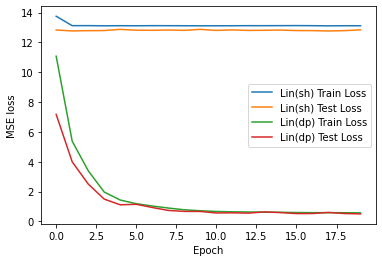

In [40]:
u.quick_loss_plot(
    mer8motif_lin_s_data_label + \
    mer8motif_lin_d_data_label
)

### CNN Model

0 0.5443477659081392
1 0.152213032662341
2 0.016931452222588635
3 0.007201085700131454
4 0.009976789559431128
5 0.017121605428792867
6 0.00309271681641959
7 0.005498628820132825
8 0.002677880951851044
9 0.002767311542462091
10 0.0022114270318681897
11 0.0022249093919570083
12 0.0032164798719070036
13 0.002189640851766474
14 0.0020028947488645262
15 0.0017370673968469218
16 0.0021432501429833636
17 0.001814969993354967
18 0.0018248914360123145
19 0.0014427950999318997


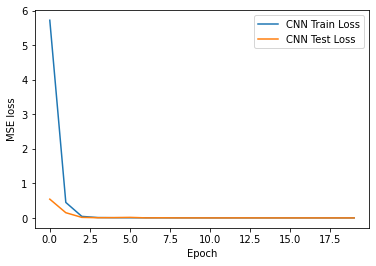

In [41]:
seq_len = len(mer8motif_train_df['seq'].values[0])

mer8motif_model_cnn = DNA_CNN(seq_len, num_filters=31,kernel_size=3)

mer8motif_train_losses_cnn, mer8motif_test_losses_cnn = u.run_model(mer8motif_train_dl, mer8motif_test_dl, mer8motif_model_cnn, lr=0.01)

# to plot loss
mer8motif_cnn_data_label = list(zip([mer8motif_train_losses_cnn,mer8motif_test_losses_cnn], ['CNN Train Loss','CNN Test Loss']))
u.quick_loss_plot(mer8motif_cnn_data_label)

In [42]:
quick_test8(mer8motif_model_cnn, oracle_8mer_motif)

AAAAAAAA: pred:20.008 actual:20.000 (-0.008)
CCCCCCCC: pred:17.005 actual:17.000 (-0.005)
GGGGGGGG: pred:14.007 actual:14.000 (-0.007)
TTTTTTTT: pred:11.006 actual:11.000 (-0.006)

AACCAACA: pred:18.891 actual:18.875 (-0.016)
CCGGCGCG: pred:5.393 actual:5.500 (0.107)
GGGTAAGG: pred:15.126 actual:15.125 (-0.001)
TTTCGTTT: pred:12.138 actual:12.125 (-0.013)
TGTAATAC: pred:15.502 actual:15.500 (-0.002)

TATAAAAA: pred:27.823 actual:27.750 (-0.073)
CCTATCCC: pred:25.878 actual:25.875 (-0.003)
GTATGGGG: pred:23.989 actual:24.000 (0.011)
TTTATTTT: pred:22.121 actual:22.125 (0.004)

AAGCGAAA: pred:8.115 actual:8.125 (0.010)
CGCGCCCC: pred:6.214 actual:6.250 (0.036)
GGGCGGGG: pred:4.370 actual:4.375 (0.005)
TTGCGTTT: pred:2.587 actual:2.500 (-0.087)

ATATGCGA: pred:15.782 actual:15.875 (0.093)
TGCGTATT: pred:14.018 actual:13.625 (-0.393)



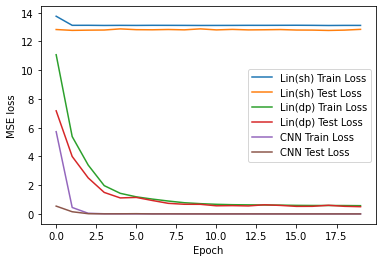

In [43]:
u.quick_loss_plot(
    mer8motif_lin_s_data_label + \
    mer8motif_lin_d_data_label + \
    mer8motif_cnn_data_label
)

Running LinearShallow_8mer


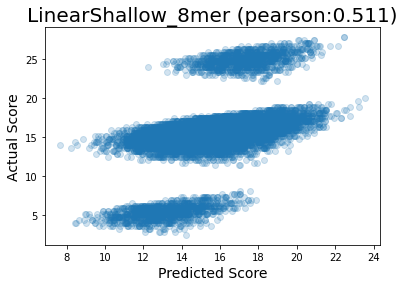

Running LinearDeep_8mer


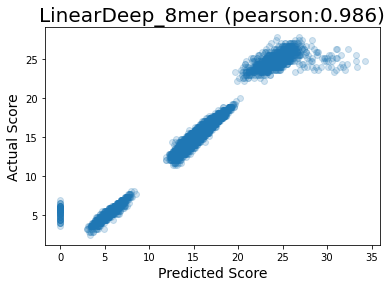

Running CNN_8mer


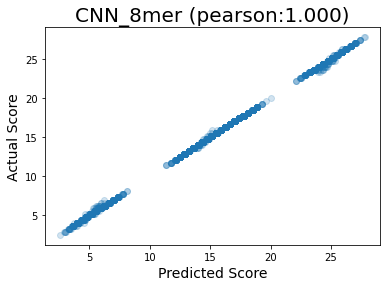

In [44]:
models = [
    ("LinearShallow_8mer",mer8motif_model_lin_s),
    ("LinearDeep_8mer",mer8motif_model_lin_d),
    ("CNN_8mer",mer8motif_model_cnn),
]

seqs = mer8motif_test_df['seq'].values
task = "TATGCGmotif"

dfs = u.parity_pred(models, seqs, oracle_8mer_motif,task,alt=True)

# inspect

### 6mer model

In [38]:
mer6motif_model_cnn

DNA_CNN(
  (conv_net): Sequential(
    (0): Conv1d(4, 31, kernel_size=(3,), stride=(1,))
    (1): ReLU(inplace=True)
    (2): Flatten(start_dim=1, end_dim=-1)
    (3): Linear(in_features=124, out_features=10, bias=True)
    (4): ReLU(inplace=True)
    (5): Linear(in_features=10, out_features=1, bias=True)
  )
)

In [39]:
conv_layers, model_weights, bias_weights = u.get_conv_layers_from_model(mer6motif_model_cnn)

Total convolutional layers: 1


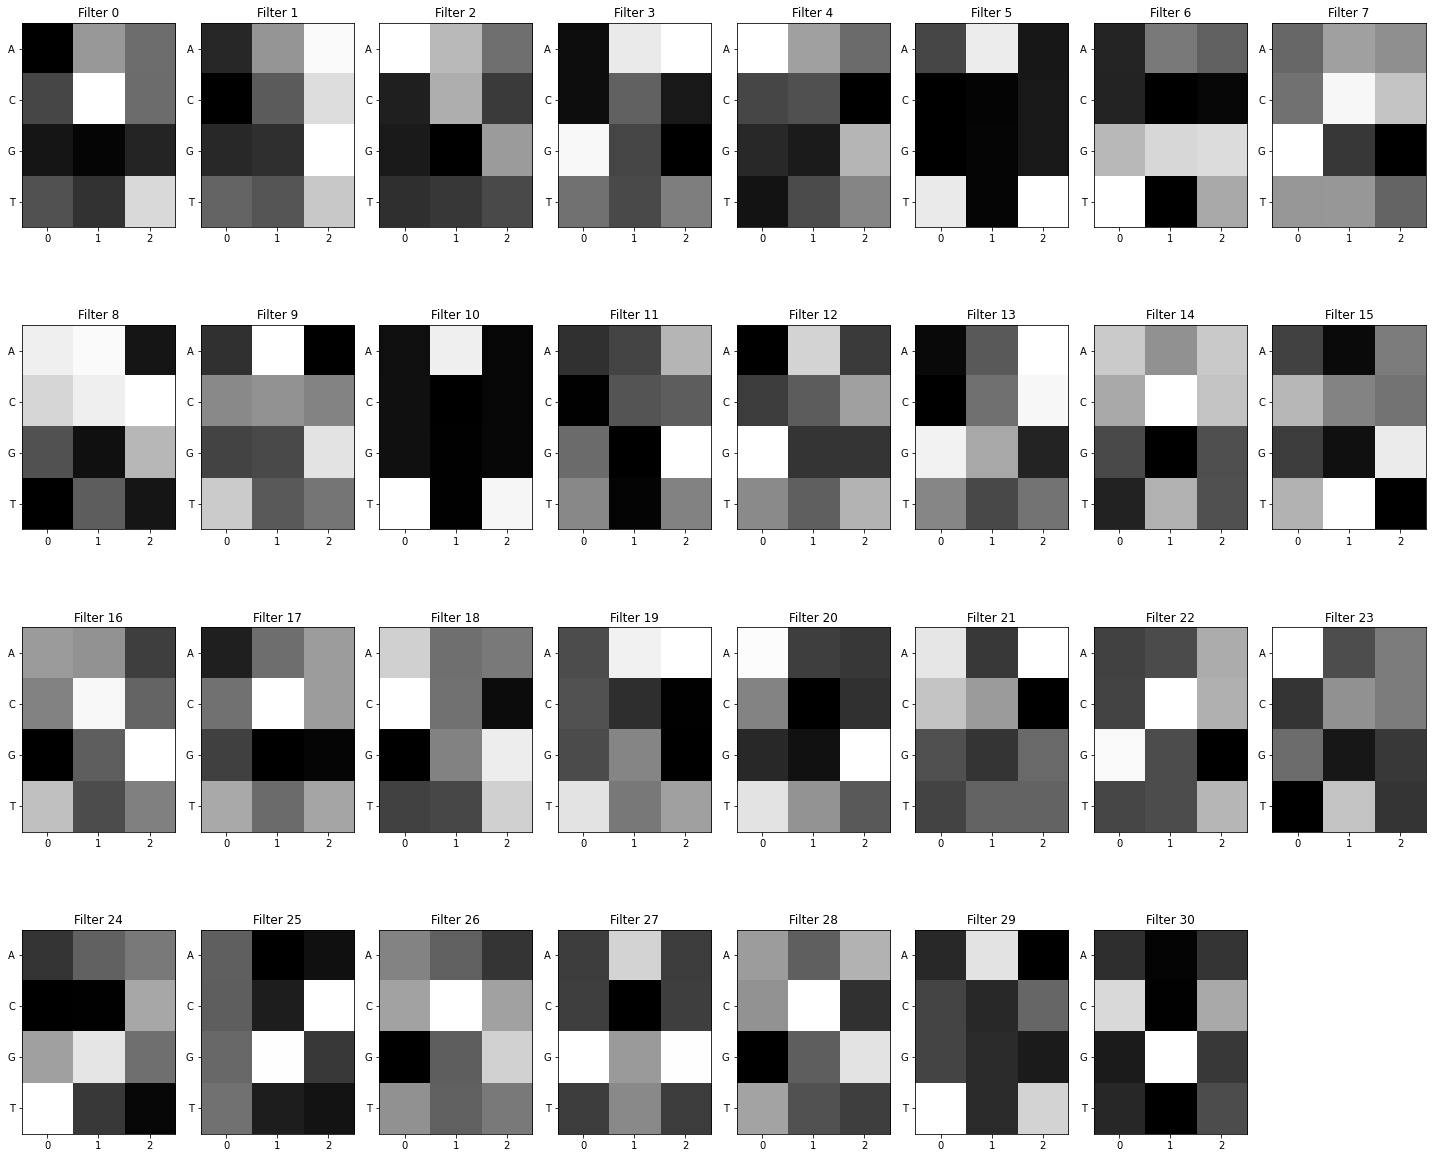

In [40]:
u.view_filters(model_weights)

In [41]:
train_seqs = list(mer6motif_train_df['seq'])
filter_activations = u.get_filter_activations(train_seqs, conv_layers[0])

Running seq AAAAAA
Running seq AAAAAC
Running seq AAAAAG
Running seq AAAAAT
Running seq AAAACA
Running seq AAAACG
Running seq AAAACT
Running seq AAAAGA
Running seq AAAAGC
Running seq AAAAGG
Running seq AAAAGT
Running seq AAAATA
Running seq AAAATC
Running seq AAAATG
Running seq AAAATT
Running seq AAACAA
Running seq AAACAG
Running seq AAACAT
Running seq AAACCA
Running seq AAACCC
Running seq AAACCG
Running seq AAACCT
Running seq AAACGG
Running seq AAACTA
Running seq AAACTC
Running seq AAACTG
Running seq AAACTT
Running seq AAAGAA
Running seq AAAGAG
Running seq AAAGAT
Running seq AAAGCC
Running seq AAAGCG
Running seq AAAGCT
Running seq AAAGGA
Running seq AAAGGG
Running seq AAAGGT
Running seq AAAGTA
Running seq AAAGTC
Running seq AAAGTT
Running seq AAATAC
Running seq AAATAG
Running seq AAATAT
Running seq AAATCA
Running seq AAATCC
Running seq AAATCT
Running seq AAATGA
Running seq AAATGC
Running seq AAATGG
Running seq AAATGT
Running seq AAATTA
Running seq AAATTC
Running seq AAATTG
Running seq 

Running seq AGATCG
Running seq AGATCT
Running seq AGATGC
Running seq AGATGG
Running seq AGATGT
Running seq AGATTA
Running seq AGATTC
Running seq AGATTG
Running seq AGATTT
Running seq AGCAAG
Running seq AGCAAT
Running seq AGCACC
Running seq AGCACG
Running seq AGCACT
Running seq AGCAGA
Running seq AGCAGC
Running seq AGCAGG
Running seq AGCAGT
Running seq AGCATC
Running seq AGCATT
Running seq AGCCAA
Running seq AGCCAG
Running seq AGCCAT
Running seq AGCCCA
Running seq AGCCCC
Running seq AGCCCG
Running seq AGCCGA
Running seq AGCCGC
Running seq AGCCGT
Running seq AGCCTA
Running seq AGCCTC
Running seq AGCCTG
Running seq AGCCTT
Running seq AGCGAA
Running seq AGCGAC
Running seq AGCGAG
Running seq AGCGAT
Running seq AGCGCT
Running seq AGCGGA
Running seq AGCGGC
Running seq AGCGGT
Running seq AGCGTA
Running seq AGCGTC
Running seq AGCGTG
Running seq AGCTAA
Running seq AGCTAG
Running seq AGCTAT
Running seq AGCTCA
Running seq AGCTCC
Running seq AGCTCG
Running seq AGCTCT
Running seq AGCTGA
Running seq 

Running seq CACTCA
Running seq CACTCC
Running seq CACTCG
Running seq CACTCT
Running seq CACTGA
Running seq CACTGC
Running seq CACTGG
Running seq CACTGT
Running seq CACTTA
Running seq CACTTC
Running seq CACTTG
Running seq CACTTT
Running seq CAGAAC
Running seq CAGAAT
Running seq CAGACA
Running seq CAGACC
Running seq CAGACG
Running seq CAGACT
Running seq CAGAGA
Running seq CAGAGC
Running seq CAGAGG
Running seq CAGAGT
Running seq CAGATA
Running seq CAGATG
Running seq CAGATT
Running seq CAGCAA
Running seq CAGCAG
Running seq CAGCAT
Running seq CAGCCC
Running seq CAGCGA
Running seq CAGCGC
Running seq CAGCGG
Running seq CAGCGT
Running seq CAGCTA
Running seq CAGCTC
Running seq CAGCTG
Running seq CAGCTT
Running seq CAGGAC
Running seq CAGGAG
Running seq CAGGAT
Running seq CAGGCA
Running seq CAGGCG
Running seq CAGGCT
Running seq CAGGGA
Running seq CAGGGC
Running seq CAGGGG
Running seq CAGGGT
Running seq CAGGTA
Running seq CAGGTC
Running seq CAGGTT
Running seq CAGTAA
Running seq CAGTAC
Running seq 

Running seq CGGCCT
Running seq CGGCGC
Running seq CGGCGG
Running seq CGGCGT
Running seq CGGCTA
Running seq CGGCTC
Running seq CGGCTG
Running seq CGGCTT
Running seq CGGGAA
Running seq CGGGAG
Running seq CGGGAT
Running seq CGGGCA
Running seq CGGGCT
Running seq CGGGGA
Running seq CGGGGG
Running seq CGGGTA
Running seq CGGGTC
Running seq CGGGTG
Running seq CGGGTT
Running seq CGGTAA
Running seq CGGTAC
Running seq CGGTAG
Running seq CGGTAT
Running seq CGGTCA
Running seq CGGTCC
Running seq CGGTCG
Running seq CGGTCT
Running seq CGGTGC
Running seq CGGTGG
Running seq CGGTGT
Running seq CGGTTC
Running seq CGTAAC
Running seq CGTAAG
Running seq CGTACA
Running seq CGTACC
Running seq CGTACT
Running seq CGTAGA
Running seq CGTAGC
Running seq CGTAGG
Running seq CGTAGT
Running seq CGTATC
Running seq CGTATT
Running seq CGTCAA
Running seq CGTCAC
Running seq CGTCAG
Running seq CGTCAT
Running seq CGTCCA
Running seq CGTCCC
Running seq CGTCCG
Running seq CGTCCT
Running seq CGTCGA
Running seq CGTCGC
Running seq 

Running seq GATATC
Running seq GATATG
Running seq GATATT
Running seq GATCAT
Running seq GATCCA
Running seq GATCCC
Running seq GATCCG
Running seq GATCCT
Running seq GATCGA
Running seq GATCGT
Running seq GATCTA
Running seq GATCTC
Running seq GATCTG
Running seq GATCTT
Running seq GATGAA
Running seq GATGAC
Running seq GATGAG
Running seq GATGCA
Running seq GATGCC
Running seq GATGCG
Running seq GATGCT
Running seq GATGGC
Running seq GATGGG
Running seq GATGTA
Running seq GATGTC
Running seq GATGTG
Running seq GATGTT
Running seq GATTAA
Running seq GATTAC
Running seq GATTAT
Running seq GATTCA
Running seq GATTCC
Running seq GATTCG
Running seq GATTCT
Running seq GATTGA
Running seq GATTGC
Running seq GATTGT
Running seq GATTTA
Running seq GATTTC
Running seq GATTTG
Running seq GATTTT
Running seq GCAAAA
Running seq GCAAAC
Running seq GCAAAT
Running seq GCAACA
Running seq GCAACC
Running seq GCAACG
Running seq GCAACT
Running seq GCAAGA
Running seq GCAAGC
Running seq GCAAGG
Running seq GCAAGT
Running seq 

Running seq GTACCT
Running seq GTACGC
Running seq GTACGG
Running seq GTACGT
Running seq GTACTA
Running seq GTACTC
Running seq GTACTG
Running seq GTACTT
Running seq GTAGAA
Running seq GTAGAG
Running seq GTAGAT
Running seq GTAGCA
Running seq GTAGCC
Running seq GTAGCT
Running seq GTAGGA
Running seq GTAGGG
Running seq GTAGGT
Running seq GTAGTA
Running seq GTAGTC
Running seq GTAGTG
Running seq GTAGTT
Running seq GTATAA
Running seq GTATAC
Running seq GTATAG
Running seq GTATAT
Running seq GTATCA
Running seq GTATCC
Running seq GTATCG
Running seq GTATCT
Running seq GTATGA
Running seq GTATGC
Running seq GTATGG
Running seq GTATGT
Running seq GTATTA
Running seq GTATTC
Running seq GTATTG
Running seq GTATTT
Running seq GTCAAC
Running seq GTCAAG
Running seq GTCAAT
Running seq GTCACA
Running seq GTCACC
Running seq GTCACG
Running seq GTCACT
Running seq GTCAGA
Running seq GTCAGC
Running seq GTCAGG
Running seq GTCAGT
Running seq GTCATA
Running seq GTCATC
Running seq GTCATG
Running seq GTCATT
Running seq 

Running seq TCAGTC
Running seq TCAGTG
Running seq TCAGTT
Running seq TCATAA
Running seq TCATAC
Running seq TCATAT
Running seq TCATCA
Running seq TCATCT
Running seq TCATGC
Running seq TCATGG
Running seq TCATTA
Running seq TCATTC
Running seq TCATTG
Running seq TCATTT
Running seq TCCAAA
Running seq TCCAAC
Running seq TCCAAG
Running seq TCCAAT
Running seq TCCACA
Running seq TCCACC
Running seq TCCACG
Running seq TCCAGA
Running seq TCCAGC
Running seq TCCAGG
Running seq TCCAGT
Running seq TCCATA
Running seq TCCATC
Running seq TCCATG
Running seq TCCCAC
Running seq TCCCCA
Running seq TCCCCC
Running seq TCCCCG
Running seq TCCCCT
Running seq TCCCGC
Running seq TCCCGG
Running seq TCCCTA
Running seq TCCCTC
Running seq TCCCTG
Running seq TCCCTT
Running seq TCCGAA
Running seq TCCGAG
Running seq TCCGCA
Running seq TCCGCC
Running seq TCCGCG
Running seq TCCGGA
Running seq TCCGGC
Running seq TCCGGG
Running seq TCCGGT
Running seq TCCGTA
Running seq TCCGTC
Running seq TCCGTG
Running seq TCCGTT
Running seq 

Running seq TTCGAA
Running seq TTCGAG
Running seq TTCGCC
Running seq TTCGCG
Running seq TTCGCT
Running seq TTCGGA
Running seq TTCGGC
Running seq TTCGGG
Running seq TTCGGT
Running seq TTCGTA
Running seq TTCGTC
Running seq TTCGTG
Running seq TTCGTT
Running seq TTCTAA
Running seq TTCTAC
Running seq TTCTAG
Running seq TTCTAT
Running seq TTCTCA
Running seq TTCTCC
Running seq TTCTCG
Running seq TTCTCT
Running seq TTCTGA
Running seq TTCTGC
Running seq TTCTGT
Running seq TTCTTA
Running seq TTCTTG
Running seq TTCTTT
Running seq TTGAAA
Running seq TTGAAC
Running seq TTGAAG
Running seq TTGAAT
Running seq TTGACC
Running seq TTGACG
Running seq TTGACT
Running seq TTGAGA
Running seq TTGAGC
Running seq TTGAGG
Running seq TTGAGT
Running seq TTGATA
Running seq TTGATC
Running seq TTGATT
Running seq TTGCAA
Running seq TTGCAC
Running seq TTGCAG
Running seq TTGCAT
Running seq TTGCCA
Running seq TTGCCC
Running seq TTGCCT
Running seq TTGCGA
Running seq TTGCGT
Running seq TTGCTC
Running seq TTGCTG
Running seq 

/home/ewilson6/anaconda3/envs/torch/lib/python3.8/site-packages/logomaker/src/Logo.py:1062: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  self.ax.set_ylim([ymin, ymax])
/home/ewilson6/anaconda3/envs/torch/lib/python3.8/site-packages/logomaker/src/Logo.py:1062: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  self.ax.set_ylim([ymin, ymax])


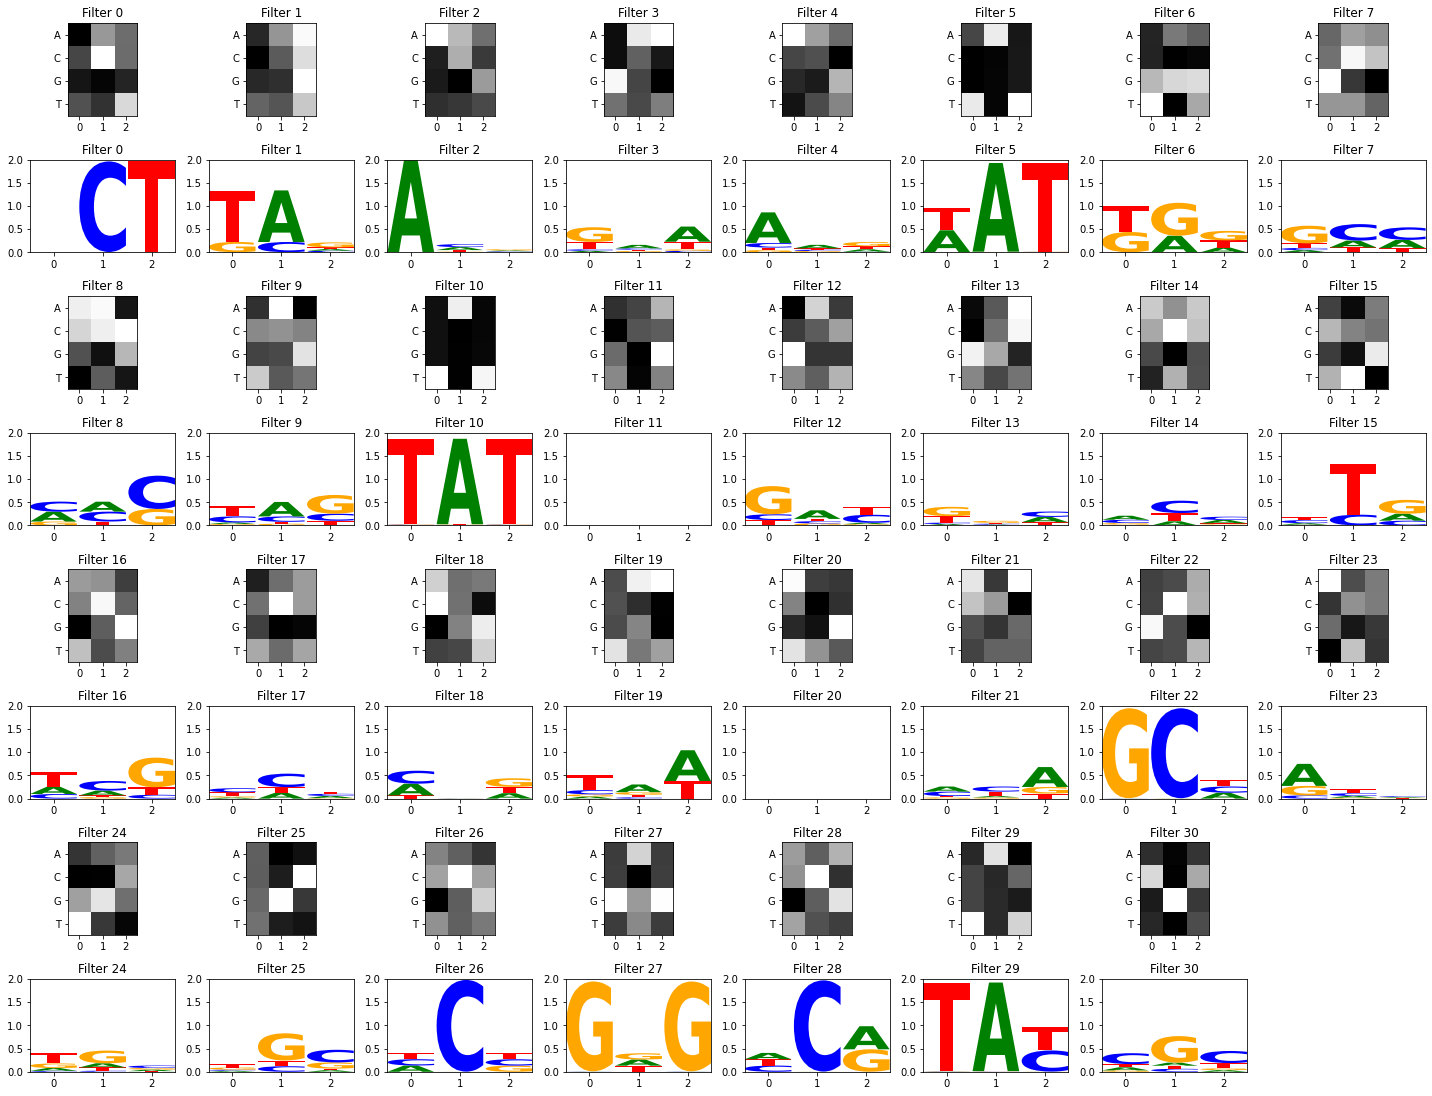

In [42]:
u.view_filters_and_logos(model_weights,filter_activations)

# 8mer model cnn

Total convolutional layers: 1


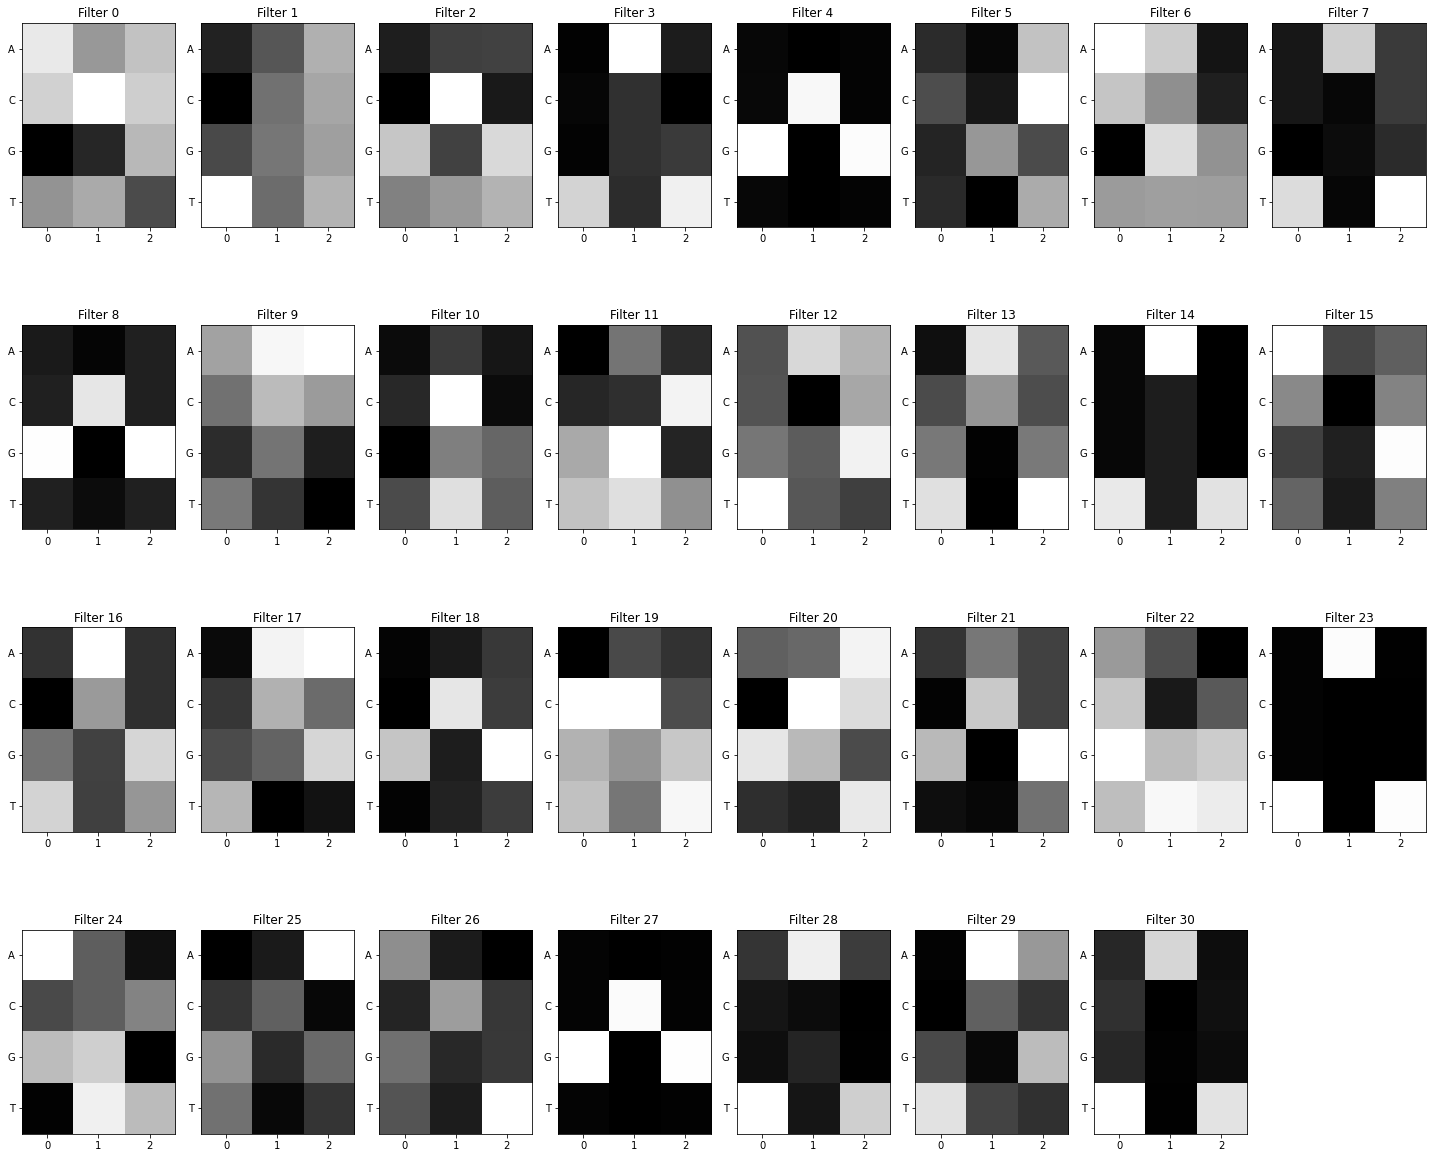

In [45]:
conv_layers, model_weights, bias_weights = u.get_conv_layers_from_model(mer8motif_model_cnn)
u.view_filters(model_weights)

In [46]:
train_seqs = list(mer6motif_train_df['seq'])# still using mer6 seqs is ok cuz just getting activations!
filter_activations = u.get_filter_activations(train_seqs, conv_layers[0])

Running seq AAAAAA
Running seq AAAAAC
Running seq AAAAAG
Running seq AAAAAT
Running seq AAAACA
Running seq AAAACG
Running seq AAAACT
Running seq AAAAGA
Running seq AAAAGC
Running seq AAAAGG
Running seq AAAAGT
Running seq AAAATA
Running seq AAAATC
Running seq AAAATG
Running seq AAAATT
Running seq AAACAA
Running seq AAACAG
Running seq AAACAT
Running seq AAACCA
Running seq AAACCC
Running seq AAACCG
Running seq AAACCT
Running seq AAACGG
Running seq AAACTA
Running seq AAACTC
Running seq AAACTG
Running seq AAACTT
Running seq AAAGAA
Running seq AAAGAG
Running seq AAAGAT
Running seq AAAGCC
Running seq AAAGCG
Running seq AAAGCT
Running seq AAAGGA
Running seq AAAGGG
Running seq AAAGGT
Running seq AAAGTA
Running seq AAAGTC
Running seq AAAGTT
Running seq AAATAC
Running seq AAATAG
Running seq AAATAT
Running seq AAATCA
Running seq AAATCC
Running seq AAATCT
Running seq AAATGA
Running seq AAATGC
Running seq AAATGG
Running seq AAATGT
Running seq AAATTA
Running seq AAATTC
Running seq AAATTG
Running seq 

Running seq AGCGTG
Running seq AGCTAA
Running seq AGCTAG
Running seq AGCTAT
Running seq AGCTCA
Running seq AGCTCC
Running seq AGCTCG
Running seq AGCTCT
Running seq AGCTGA
Running seq AGCTGT
Running seq AGCTTA
Running seq AGCTTC
Running seq AGCTTG
Running seq AGCTTT
Running seq AGGAAA
Running seq AGGAAC
Running seq AGGAAG
Running seq AGGAAT
Running seq AGGACA
Running seq AGGACC
Running seq AGGACG
Running seq AGGACT
Running seq AGGAGA
Running seq AGGAGC
Running seq AGGAGG
Running seq AGGAGT
Running seq AGGATA
Running seq AGGATC
Running seq AGGATG
Running seq AGGATT
Running seq AGGCAA
Running seq AGGCAG
Running seq AGGCCC
Running seq AGGCCT
Running seq AGGCGA
Running seq AGGCGC
Running seq AGGCGG
Running seq AGGCGT
Running seq AGGCTA
Running seq AGGCTG
Running seq AGGCTT
Running seq AGGGAC
Running seq AGGGAG
Running seq AGGGAT
Running seq AGGGCA
Running seq AGGGCG
Running seq AGGGGA
Running seq AGGGGC
Running seq AGGGGG
Running seq AGGGGT
Running seq AGGGTA
Running seq AGGGTG
Running seq 

Running seq CATCAA
Running seq CATCAG
Running seq CATCAT
Running seq CATCCA
Running seq CATCCT
Running seq CATCGG
Running seq CATCGT
Running seq CATCTA
Running seq CATCTT
Running seq CATGAA
Running seq CATGAG
Running seq CATGAT
Running seq CATGCA
Running seq CATGCC
Running seq CATGCG
Running seq CATGCT
Running seq CATGGA
Running seq CATGGG
Running seq CATGTA
Running seq CATGTC
Running seq CATGTG
Running seq CATGTT
Running seq CATTAA
Running seq CATTAC
Running seq CATTAG
Running seq CATTAT
Running seq CATTCA
Running seq CATTCC
Running seq CATTCT
Running seq CATTGA
Running seq CATTGC
Running seq CATTGG
Running seq CATTGT
Running seq CATTTA
Running seq CATTTG
Running seq CATTTT
Running seq CCAAAA
Running seq CCAAAG
Running seq CCAAAT
Running seq CCAACA
Running seq CCAACG
Running seq CCAACT
Running seq CCAAGA
Running seq CCAAGC
Running seq CCAAGG
Running seq CCAAGT
Running seq CCAATA
Running seq CCAATC
Running seq CCAATG
Running seq CCAATT
Running seq CCACAC
Running seq CCACAG
Running seq 

Running seq CTACAC
Running seq CTACAG
Running seq CTACAT
Running seq CTACCA
Running seq CTACCC
Running seq CTACCT
Running seq CTACGA
Running seq CTACGC
Running seq CTACGG
Running seq CTACGT
Running seq CTACTA
Running seq CTACTC
Running seq CTACTG
Running seq CTACTT
Running seq CTAGAA
Running seq CTAGAC
Running seq CTAGAG
Running seq CTAGAT
Running seq CTAGCA
Running seq CTAGCC
Running seq CTAGCG
Running seq CTAGCT
Running seq CTAGGC
Running seq CTAGGG
Running seq CTAGGT
Running seq CTAGTA
Running seq CTAGTC
Running seq CTATAA
Running seq CTATAC
Running seq CTATAG
Running seq CTATAT
Running seq CTATCC
Running seq CTATCG
Running seq CTATCT
Running seq CTATGC
Running seq CTATGT
Running seq CTATTA
Running seq CTATTC
Running seq CTATTG
Running seq CTCAAA
Running seq CTCAAC
Running seq CTCAAG
Running seq CTCAAT
Running seq CTCACA
Running seq CTCACC
Running seq CTCACG
Running seq CTCACT
Running seq CTCAGA
Running seq CTCAGC
Running seq CTCAGG
Running seq CTCATA
Running seq CTCATC
Running seq 

Running seq GCCCGC
Running seq GCCCGG
Running seq GCCCTA
Running seq GCCCTC
Running seq GCCCTG
Running seq GCCGAC
Running seq GCCGAG
Running seq GCCGAT
Running seq GCCGCA
Running seq GCCGCC
Running seq GCCGCG
Running seq GCCGCT
Running seq GCCGGA
Running seq GCCGGC
Running seq GCCGGG
Running seq GCCGGT
Running seq GCCGTA
Running seq GCCGTC
Running seq GCCGTG
Running seq GCCGTT
Running seq GCCTAA
Running seq GCCTAC
Running seq GCCTAG
Running seq GCCTAT
Running seq GCCTCC
Running seq GCCTCT
Running seq GCCTGA
Running seq GCCTGC
Running seq GCCTGG
Running seq GCCTGT
Running seq GCCTTA
Running seq GCCTTC
Running seq GCCTTG
Running seq GCCTTT
Running seq GCGAAA
Running seq GCGAAC
Running seq GCGAAG
Running seq GCGAAT
Running seq GCGACA
Running seq GCGAGA
Running seq GCGAGC
Running seq GCGAGG
Running seq GCGAGT
Running seq GCGATC
Running seq GCGATG
Running seq GCGATT
Running seq GCGCAA
Running seq GCGCAG
Running seq GCGCAT
Running seq GCGCCA
Running seq GCGCCC
Running seq GCGCGA
Running seq 

Running seq GTGAAG
Running seq GTGAAT
Running seq GTGACC
Running seq GTGACG
Running seq GTGACT
Running seq GTGAGA
Running seq GTGAGC
Running seq GTGAGG
Running seq GTGAGT
Running seq GTGATA
Running seq GTGATC
Running seq GTGATG
Running seq GTGATT
Running seq GTGCCA
Running seq GTGCCC
Running seq GTGCCG
Running seq GTGCGA
Running seq GTGCGC
Running seq GTGCGG
Running seq GTGCGT
Running seq GTGCTA
Running seq GTGCTC
Running seq GTGCTG
Running seq GTGCTT
Running seq GTGGAA
Running seq GTGGAC
Running seq GTGGAG
Running seq GTGGAT
Running seq GTGGCA
Running seq GTGGCC
Running seq GTGGCG
Running seq GTGGGA
Running seq GTGGGC
Running seq GTGGGT
Running seq GTGGTA
Running seq GTGGTC
Running seq GTGGTG
Running seq GTGGTT
Running seq GTGTAA
Running seq GTGTAC
Running seq GTGTAG
Running seq GTGTCA
Running seq GTGTCC
Running seq GTGTCG
Running seq GTGTCT
Running seq GTGTGA
Running seq GTGTGC
Running seq GTGTGG
Running seq GTGTGT
Running seq GTGTTC
Running seq GTGTTG
Running seq GTGTTT
Running seq 

Running seq TCGGTA
Running seq TCGGTC
Running seq TCGGTT
Running seq TCGTAA
Running seq TCGTAG
Running seq TCGTAT
Running seq TCGTCA
Running seq TCGTCC
Running seq TCGTCG
Running seq TCGTCT
Running seq TCGTGA
Running seq TCGTGC
Running seq TCGTGG
Running seq TCGTGT
Running seq TCGTTA
Running seq TCGTTG
Running seq TCGTTT
Running seq TCTAAA
Running seq TCTAAG
Running seq TCTAAT
Running seq TCTACA
Running seq TCTACC
Running seq TCTACG
Running seq TCTACT
Running seq TCTAGA
Running seq TCTAGG
Running seq TCTAGT
Running seq TCTATA
Running seq TCTATC
Running seq TCTATG
Running seq TCTATT
Running seq TCTCAA
Running seq TCTCAC
Running seq TCTCAG
Running seq TCTCAT
Running seq TCTCCA
Running seq TCTCCC
Running seq TCTCCG
Running seq TCTCCT
Running seq TCTCGC
Running seq TCTCGT
Running seq TCTCTA
Running seq TCTCTC
Running seq TCTCTG
Running seq TCTCTT
Running seq TCTGAG
Running seq TCTGAT
Running seq TCTGCC
Running seq TCTGCG
Running seq TCTGCT
Running seq TCTGGA
Running seq TCTGGG
Running seq 

Running seq TTTCCG
Running seq TTTCCT
Running seq TTTCGA
Running seq TTTCGC
Running seq TTTCGG
Running seq TTTCGT
Running seq TTTCTA
Running seq TTTCTG
Running seq TTTCTT
Running seq TTTGAC
Running seq TTTGAG
Running seq TTTGCA
Running seq TTTGCC
Running seq TTTGCG
Running seq TTTGGA
Running seq TTTGGC
Running seq TTTGGG
Running seq TTTGGT
Running seq TTTGTA
Running seq TTTGTC
Running seq TTTGTG
Running seq TTTTAA
Running seq TTTTAG
Running seq TTTTAT
Running seq TTTTCA
Running seq TTTTCC
Running seq TTTTCT
Running seq TTTTGA
Running seq TTTTGC
Running seq TTTTGG
Running seq TTTTTA
Running seq TTTTTC
Running seq TTTTTG
Running seq TTTTTT


/home/ewilson6/anaconda3/envs/torch/lib/python3.8/site-packages/logomaker/src/Logo.py:1062: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  self.ax.set_ylim([ymin, ymax])
/home/ewilson6/anaconda3/envs/torch/lib/python3.8/site-packages/logomaker/src/Logo.py:1062: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  self.ax.set_ylim([ymin, ymax])
/home/ewilson6/anaconda3/envs/torch/lib/python3.8/site-packages/logomaker/src/Logo.py:1062: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  self.ax.set_ylim([ymin, ymax])
/home/ewilson6/anaconda3/envs/torch/lib/python3.8/site-packages/logomaker/src/Logo.py:1062: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  self.ax.set_ylim([ymin, ymax])
/hom

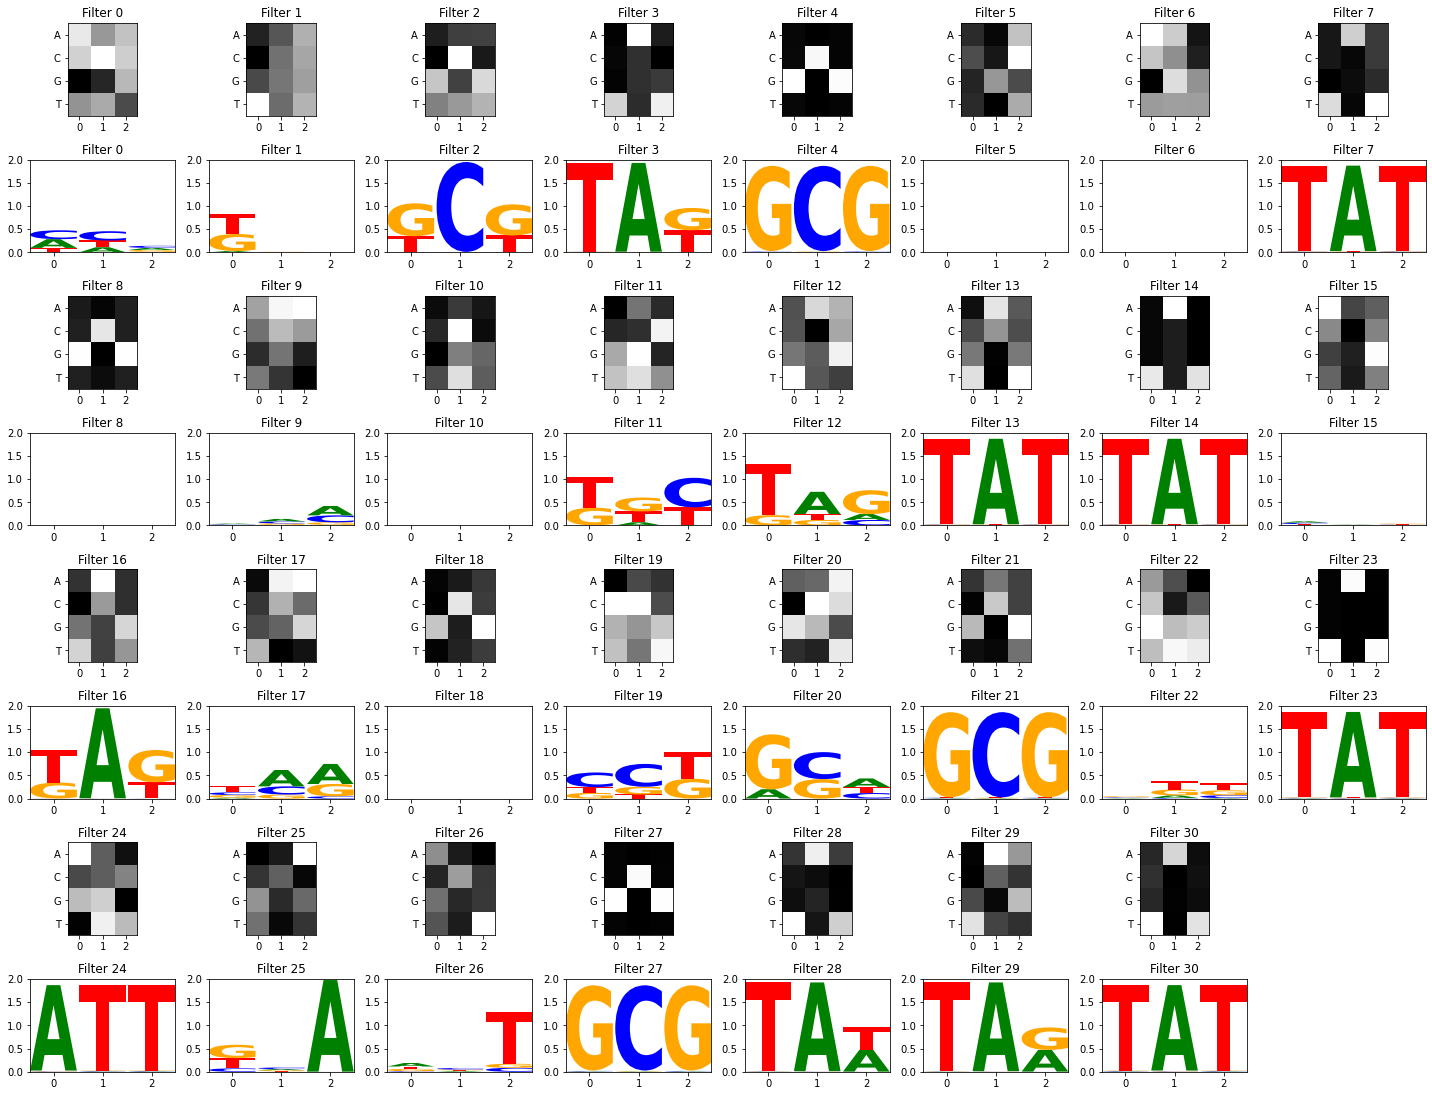

In [47]:
u.view_filters_and_logos(model_weights,filter_activations)

# Try LSTMs

In [46]:
# mer8motif_train_dl,\
# mer8motif_test_dl, \
# mer8motif_train_df, \
# mer8motif_test_df = u.build_dataloaders_single(mer8_motif,batch_size=11)
# change to batch size 11 so I can figure out the dimension errors

In [47]:
# class DNA_LSTM(nn.Module):
#     def __init__(self,
#                  seq_len,
#                  hidden_dim=10,
#                  layer1_dim=12,
#                  #layer2_dim=12
#                 ):
#         super().__init__()
#         self.seq_len = seq_len
#         self.hidden_dim = hidden_dim
        
#         self.hidden_init_values = None
#         self.hidden = self.init_hidden() # tuple of hidden state and cell state
        
#         self.rnn = nn.LSTM(4, hidden_dim,batch_first=True)
# #         self.fc = nn.Sequential(
# #             nn.ReLU(inplace=True),
# #             #nn.Flatten(),
# #             nn.Linear(hidden_dim, layer1_dim),
# #             nn.ReLU(inplace=True),
# #             nn.Linear(layer1_dim, 1),
# #         )
#         self.fc = nn.Linear(hidden_dim, 1)
            
# #         self.rnn = nn.Sequential(
# #             nn.LSTM(4, hidden_dim),
# #             nn.ReLU(inplace=True),
# #             nn.Flatten(),
# #             nn.Linear(hidden_dim, layer1_dim),
# #             nn.ReLU(inplace=True),
# #             nn.Linear(layer1_dim, 1),
# #         ) 
    
#     def init_hidden(self):
#         if self.hidden_init_values == None:
#             self.hidden_init_values = (autograd.Variable(torch.randn(1, 1, self.hidden_dim)),
#                                        autograd.Variable(torch.randn(1, 1, self.hidden_dim)))
#         return self.hidden_init_values
#         #hidden_state = torch.randn(n_layers, batch_size, hidden_dim)
    

#     def forward(self, xb):
#         # WRONG? reshape view to batch_ssize x 4channel x seq_len
#         # for LSTM? reshape view to seq_len x batch_ssize x 4channel  
#         # permute to put channel in correct order
#         print("original xb.shape:", xb.shape)
#         print(xb)
#         xb = xb.view(-1,self.seq_len,4)#.permute(1,0,2) 
#         print("re-viewed xb.shape:", xb.shape) # >> 11, 8, 4
#         print(xb)
#         #print(xb[0])
#         #print("xb shape", xb.shape)

#         # ** Init hidden temp **
#         batch_size = xb.shape[0]
#         print("batch_size:",batch_size)
#         (h, c) =  (torch.zeros(1, batch_size, self.hidden_dim), torch.zeros(1, batch_size, self.hidden_dim)) 
#         # *******
        
#         lstm_out, self.hidden = self.rnn(xb, (h,c)) # should this get H and C?
#         print("lstm_out",lstm_out)
#         print("^^^^^lstm_out shape:",lstm_out.shape) # >> 11, 8, 10
#         print("lstm_out[-1] shape:",lstm_out[-1].shape)
#         print("lstm_out[-1][-1] shape:",lstm_out[-1][-1].shape)
#         print("hidden len:",len(self.hidden))
#         print("hidden[0] shape:", self.hidden[0].shape)
#         print("hidden[0][-1] shape:", self.hidden[0][-1].shape)
#         print("hidden[0][-1][-1] shape:", self.hidden[0][-1][-1].shape)
        
#         print("*****")
#         A = lstm_out[-1][-1]
#         B = self.hidden[0][-1][-1]
#         print("lstm_out[-1][-1]:",A)
#         print("self.hidden[0][-1][-1]",B)
#         print("==?", A==B)
#         print("*****")
        
#         #linear_in = lstm_out.contiguous().view(-1, self.hidden_dim)
#         #print("Linear In shape:", linear_in.shape)
#         #print("self.hidden",self.hidden)
#         #print(self.hidden[1].shape)
#         #out = self.fc(linear_in)
#         out = self.fc(lstm_out)
#         #print("out",out)
#         print("LSTM->FC out shape:",out.shape)
#         return out

In [48]:
class DNA_LSTM(nn.Module):
    def __init__(self,seq_len,hidden_dim=10):
        super().__init__()
        self.seq_len = seq_len

        self.hidden_dim = hidden_dim
        self.hidden = None # when initialized, should be tuple of (hidden state, cell state)
        
        self.rnn = nn.LSTM(4, hidden_dim,batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)
            

    
    def init_hidden(self,batch_size):
        # initialize hidden and cell states with 0s
        self.hidden =  (torch.zeros(1, batch_size, self.hidden_dim), 
                        torch.zeros(1, batch_size, self.hidden_dim))
        return self.hidden
        #hidden_state = torch.randn(n_layers, batch_size, hidden_dim)
    

    def forward(self, xb,verbose=False):
        if verbose:
            print("original xb.shape:", xb.shape)
            print(xb) # 11 x 32
        
        # make the one-hot nucleotide vectors group together
        xb = xb.view(-1,self.seq_len,4) 
        if verbose:
            print("re-viewed xb.shape:", xb.shape) # >> 11 x 8 x 4
            print(xb)

        # ** Init hidden/cell states?? **
        batch_size = xb.shape[0]
        if verbose:
            print("batch_size:",batch_size)
        (h,c) = self.init_hidden(batch_size)
         
        # *******
        
        lstm_out, self.hidden = self.rnn(xb, (h,c)) # should this get H and C?
        if verbose:
            #print("lstm_out",lstm_out)
            print("lstm_out shape:",lstm_out.shape) # >> 11, 8, 10
            print("lstm_out[-1] shape:",lstm_out[-1].shape) # >> 8 x 10
            print("lstm_out[-1][-1] shape:",lstm_out[-1][-1].shape) # 10

            print("hidden len:",len(self.hidden)) # 2
            print("hidden[0] shape:", self.hidden[0].shape) # >> 1 x 11 x 10
            print("hidden[0][-1] shape:", self.hidden[0][-1].shape) # >> 11 X 10
            print("hidden[0][-1][-1] shape:", self.hidden[0][-1][-1].shape) # >> 10

            print("*****")
            # These vectors should be the same, right?
            A = lstm_out[-1][-1]
            B = self.hidden[0][-1][-1]
            print("lstm_out[-1][-1]:",A)
            print("self.hidden[0][-1][-1]",B)
            print("==?", A==B)
            print("*****")
        
        # attempt to get the last layer from each last position of 
        # all seqs in the batch? IS this the right thing to get?
        last_layer = lstm_out[:,-1,:] # This is 11X10... and it makes FC out 11X1, which is what I want?
        #last_layer = lstm_out[-1][-1].unsqueeze(0) # this was [10X1]? led to FC outoput being [1]?
        if verbose:
            print("last layer:", last_layer.shape)

        out = self.fc(last_layer) 
        if verbose:
            print("LSTM->FC out shape:",out.shape)   
                                                
        return out

In [50]:
seq_len = len(mer8motif_train_df['seq'].values[0])

mer8motif_model_lstm = DNA_LSTM(seq_len)
mer8motif_model_lstm

DNA_LSTM(
  (rnn): LSTM(4, 10, batch_first=True)
  (fc): Linear(in_features=10, out_features=1, bias=True)
)

In [51]:
mer8motif_train_losses_lstm,\
mer8motif_test_losses_lstm = u.run_model(
    mer8motif_train_dl, 
    mer8motif_test_dl, 
    mer8motif_model_lstm
)


0 5.482639772272397
1 0.20720879422079547
2 0.10304451005793096
3 0.061557350766912974
4 0.06122919900580413
5 0.04016574221205047
6 0.044529777883259576
7 0.029307279102393415
8 0.028446515313149873
9 0.02376602609189404
10 0.03057173010807906
11 0.019461014381394432
12 0.02092862046221547
13 0.01722342472791025
14 0.015123907362735016
15 0.017284561186201294
16 0.01562197680638658
17 0.013244265430012355
18 0.011806105203458487
19 0.011503140126913588


In [52]:
quick_test8(mer8motif_model_lstm, oracle_8mer_motif)

AAAAAAAA: pred:19.669 actual:20.000 (0.331)
CCCCCCCC: pred:17.031 actual:17.000 (-0.031)
GGGGGGGG: pred:13.976 actual:14.000 (0.024)
TTTTTTTT: pred:10.856 actual:11.000 (0.144)

AACCAACA: pred:18.904 actual:18.875 (-0.029)
CCGGCGCG: pred:5.525 actual:5.500 (-0.025)
GGGTAAGG: pred:15.201 actual:15.125 (-0.076)
TTTCGTTT: pred:12.082 actual:12.125 (0.043)
TGTAATAC: pred:15.513 actual:15.500 (-0.013)

TATAAAAA: pred:27.596 actual:27.750 (0.154)
CCTATCCC: pred:25.732 actual:25.875 (0.143)
GTATGGGG: pred:23.787 actual:24.000 (0.213)
TTTATTTT: pred:21.512 actual:22.125 (0.613)

AAGCGAAA: pred:8.075 actual:8.125 (0.050)
CGCGCCCC: pred:6.440 actual:6.250 (-0.190)
GGGCGGGG: pred:4.335 actual:4.375 (0.040)
TTGCGTTT: pred:2.910 actual:2.500 (-0.410)

ATATGCGA: pred:16.169 actual:15.875 (-0.294)
TGCGTATT: pred:14.399 actual:13.625 (-0.774)



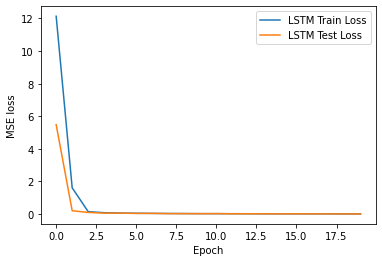

In [53]:
mer8motif_lstm_data_label = list(zip([mer8motif_train_losses_lstm,mer8motif_test_losses_lstm], ['LSTM Train Loss','LSTM Test Loss']))
u.quick_loss_plot(mer8motif_lstm_data_label)

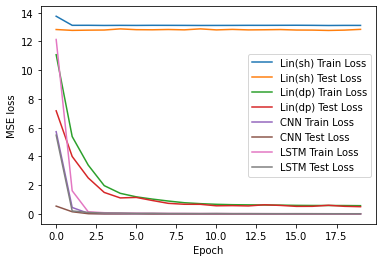

In [54]:
u.quick_loss_plot(
    mer8motif_lin_s_data_label + \
    mer8motif_lin_d_data_label + \
    mer8motif_cnn_data_label + \
    mer8motif_lstm_data_label
)

# Try CNN + LSTM

In [55]:
class DNA_CNNLSTM(nn.Module):
    def __init__(self,
                 seq_len,
                 hidden_dim=10,
                 num_filters=32,
                 kernel_size=3):
        super().__init__()
        self.seq_len = seq_len
        
        self.conv_net = nn.Sequential(
            nn.Conv1d(4, num_filters, kernel_size=kernel_size),
            nn.ReLU(inplace=True),
        ) 
        
        self.hidden_dim = hidden_dim
        self.hidden = None # when initialized, should be tuple of (hidden state, cell state)
        
        self.rnn = nn.LSTM(num_filters, hidden_dim,batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)
            
    def init_hidden(self,batch_size):
        # initialize hidden and cell states with 0s
        self.hidden =  (torch.zeros(1, batch_size, self.hidden_dim), 
                        torch.zeros(1, batch_size, self.hidden_dim))
        return self.hidden
        #hidden_state = torch.randn(n_layers, batch_size, hidden_dim)

    def forward(self, xb, verbose=False):
        # reshape view to batch_ssize x 4channel x seq_len
        # permute to put channel in correct order
        xb = xb.view(-1,self.seq_len,4).permute(0,2,1) 
        if verbose:
            print("xb reviewed shape:",xb.shape)

        cnn_out = self.conv_net(xb)
        if verbose:
            print("CNN out shape:",cnn_out.shape)
        cnn_out_perm = cnn_out.permute(0,2,1)
        if verbose:
            print("CNN permute out shape:",cnn_out_perm.shape)
        
        batch_size = xb.shape[0]
        if verbose:
            print("batch_size:",batch_size)
        (h,c) = self.init_hidden(batch_size)
        
        lstm_out, self.hidden = self.rnn(cnn_out_perm, (h,c)) # should this get H and C?
        
        last_layer = lstm_out[:,-1,:] # This is 11X10... and it makes FC out 11X1, which is what I want?
        if verbose:
            print("last layer:", last_layer.shape)

        out = self.fc(last_layer) 
        if verbose:
            print("LSTM->FC out shape:",out.shape)        
        
        return out

In [56]:
seq_len = len(mer8motif_train_df['seq'].values[0])

mer8motif_model_cnnlstm = DNA_CNNLSTM(seq_len)
mer8motif_model_cnnlstm

DNA_CNNLSTM(
  (conv_net): Sequential(
    (0): Conv1d(4, 32, kernel_size=(3,), stride=(1,))
    (1): ReLU(inplace=True)
  )
  (rnn): LSTM(32, 10, batch_first=True)
  (fc): Linear(in_features=10, out_features=1, bias=True)
)

In [57]:
mer8motif_train_losses_cnnlstm,\
mer8motif_test_losses_cnnlstm = u.run_model(
    mer8motif_train_dl, 
    mer8motif_test_dl, 
    mer8motif_model_cnnlstm, 
)


0 0.0876547576336879
1 0.04249958451001044
2 0.02413250248075122
3 0.020523843873359846
4 0.012054300003604487
5 0.009947507342254459
6 0.009897500425468457
7 0.007924331076627428
8 0.006866361782377193
9 0.005744689862122655
10 0.005593913472983863
11 0.005798697677849976
12 0.004691510910346377
13 0.004572586285285802
14 0.004020758334145565
15 0.003920946594956729
16 0.0037218595322445398
17 0.0037923764930274948
18 0.0035863559552632342
19 0.0032435089164590566


AAAAAAAA: pred:19.817 actual:20.000 (0.183)
CCCCCCCC: pred:16.987 actual:17.000 (0.013)
GGGGGGGG: pred:13.956 actual:14.000 (0.044)
TTTTTTTT: pred:11.008 actual:11.000 (-0.008)

AACCAACA: pred:18.764 actual:18.875 (0.111)
CCGGCGCG: pred:5.604 actual:5.500 (-0.104)
GGGTAAGG: pred:15.192 actual:15.125 (-0.067)
TTTCGTTT: pred:12.193 actual:12.125 (-0.068)
TGTAATAC: pred:15.426 actual:15.500 (0.074)

TATAAAAA: pred:27.539 actual:27.750 (0.211)
CCTATCCC: pred:25.990 actual:25.875 (-0.115)
GTATGGGG: pred:23.982 actual:24.000 (0.018)
TTTATTTT: pred:22.223 actual:22.125 (-0.098)

AAGCGAAA: pred:7.950 actual:8.125 (0.175)
CGCGCCCC: pred:6.146 actual:6.250 (0.104)
GGGCGGGG: pred:4.367 actual:4.375 (0.008)
TTGCGTTT: pred:2.486 actual:2.500 (0.014)

ATATGCGA: pred:16.171 actual:15.875 (-0.296)
TGCGTATT: pred:13.178 actual:13.625 (0.447)



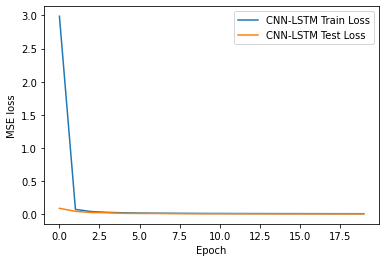

In [58]:
quick_test8(mer8motif_model_cnnlstm, oracle_8mer_motif)

mer8motif_cnnlstm_data_label = list(zip([mer8motif_train_losses_cnnlstm,mer8motif_test_losses_cnnlstm], ['CNN-LSTM Train Loss','CNN-LSTM Test Loss']))
u.quick_loss_plot(mer8motif_cnnlstm_data_label)

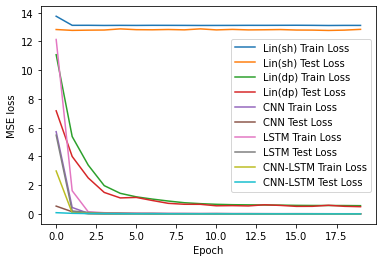

In [59]:
u.quick_loss_plot(
    mer8motif_lin_s_data_label + \
    mer8motif_lin_d_data_label + \
    mer8motif_cnn_data_label + \
    mer8motif_lstm_data_label + \
    mer8motif_cnnlstm_data_label
)

Running LinearShallow_8mer


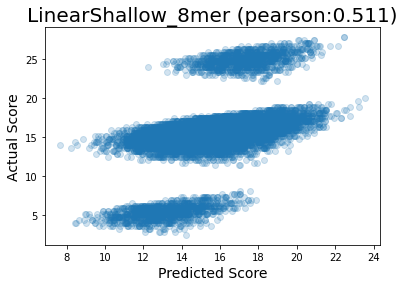

Running LinearDeep_8mer


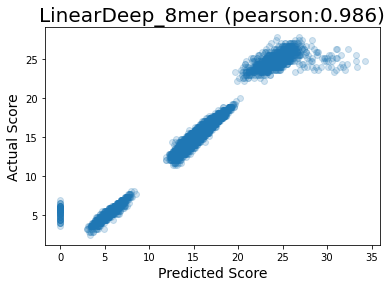

Running CNN_8mer


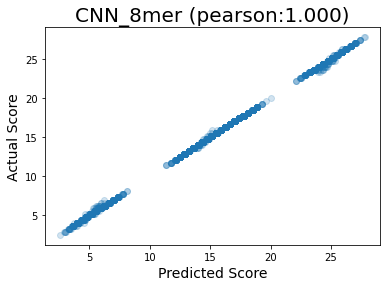

Running LSTM_8mer


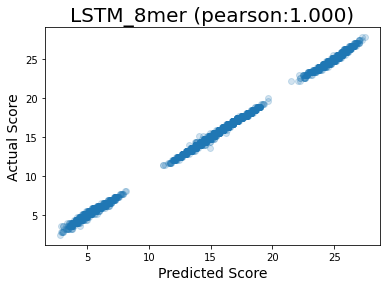

Running CNN+LSTM_8mer


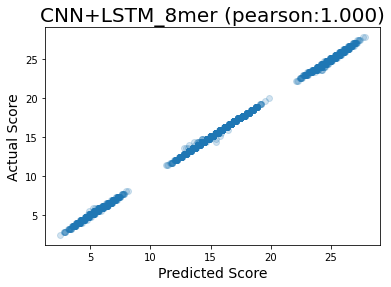

In [60]:
models = [
    ("LinearShallow_8mer",mer8motif_model_lin_s),
    ("LinearDeep_8mer",mer8motif_model_lin_d),
    ("CNN_8mer",mer8motif_model_cnn),
    ("LSTM_8mer",mer8motif_model_lstm),
    ("CNN+LSTM_8mer",mer8motif_model_cnnlstm),
]

seqs = mer8motif_test_df['seq'].values
task = "TATGCGmotif"

dfs = u.parity_pred(models, seqs, oracle_8mer_motif,task,alt=True)